In [4]:
import pandas as pd
import matplotlib
import math
import numpy as np
import requests
import json
from matplotlib import pyplot as plt
from matplotlib import style
from sklearn import preprocessing
style.use('ggplot')
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Methods
First we need to define some methods.

In [273]:
def area_effective_diversity_species(trees_set_dataframe):
    """Calculates the effective diversity of a given area in terms of species.
  
    Args:
        trees_set_dataframe: A Pandas DataFrame expected to contain data
        about trees in a specific area.
    Returns:
        A float number that represents the effective diversity.
    """
    import math
    sum_DIV = 0
    
    num_trees_per_species = trees_set_dataframe.groupby(['uqam_code'])['tree_id'].count()
    total_abundance = len(trees_set_dataframe)
    for name,num_individuals in num_trees_per_species.items(): 
        DIV = num_individuals/total_abundance* math.log(num_individuals/total_abundance)
        sum_DIV += abs(DIV)
        
    return math.exp(sum_DIV)

def area_species_richness(trees_set_dataframe):
    """Calculates the richness of a given area in terms of species diversity.
  
    Args:
        trees_set_dataframe: A Pandas DataFrame expected to contain data
        about trees in a specific area.
    Returns:
        A float number that represents the richness.
    """
    return trees_set_dataframe.uqam_code.nunique()

def area_effective_diversity_groups(trees_set_dataframe):
    """Calculates the effective diversity of a given area in terms of functional groups.
  
    Args:
        trees_set_dataframe: A Pandas DataFrame expected to contain data
            about trees in a specific area.
    Returns:
        A float number that represents the effective diversity.
    """
    import math
    sum_DIV = 0
    
    num_trees_per_species = trees_set_dataframe.groupby(['func_group'])['tree_id'].count()
    total_abundance = len(trees_set_dataframe)
    for name,num_individuals in num_trees_per_species.items(): 
        DIV = num_individuals/total_abundance* math.log(num_individuals/total_abundance)
        sum_DIV += abs(DIV)
        
    return math.exp(sum_DIV)

def improvement_effective_diversity_species(new_species, curr_effect_diversity, curr_richness, trees_set_dataframe):
    """Calculates the improvement that a new tree would cause in a given area,
        in terms of species effective diversity.
  
    Args:
        new_species: string that represents the name of the new species that is beeing added to the area.
        curr_effect_diversity: current effective diversity of the area (species).
        curr_richness: current richness of the area (species).
        trees_set_dataframe: A Pandas DataFrame expected to contain data
            about trees in a specific area. 
    Returns:
        A float number that represents the improvement.
    """
    
    import math
    
    # If new group is not defined
    if type(new_species) != str:
        return 0
    total_abundance = len(trees_set_dataframe)
    num_individuals = trees_set_dataframe.groupby(['uqam_code'])['tree_id'].count()[new_species]
    if num_individuals == 1:
        previous_DIV = 0
    else:
        previous_DIV = abs((num_individuals-1)/(total_abundance-1)* math.log((num_individuals-1)/(total_abundance-1)))
    DIV = abs(num_individuals/total_abundance* math.log(num_individuals/total_abundance))
    return math.exp(DIV - previous_DIV)-1

def improvement_richness_species(curr_richness, trees_set_dataframe):
    """Calculates the improvement that a new tree would cause in a given area,
        in terms of species richness.
  
    Args:
        curr_richness: current richness of the area (species).
        trees_set_dataframe: A Pandas DataFrame expected to contain data
            about trees in a specific area.         
    Returns:
        A float number that represents the improvement.
    """
    return (trees_set_dataframe.uqam_code.nunique()/curr_richness) - 1


def area_groups_richness(trees_set_dataframe):
    """Calculates the richness of a given area in terms of functional groups diversity.
  
    Args:
        trees_set_dataframe: A Pandas DataFrame expected to contain data
        about trees in a specific area.
    Returns:
        A float number that represents the richness.
    """
    return trees_set_dataframe.func_group.nunique()

def improvement_richness_groups(curr_richness, trees_set_dataframe):
    """Calculates the improvement that a new tree would cause in a given area,
        in terms of functional group richness.
  
    Args:
        curr_richness: current richness of the area (groups).
        trees_set_dataframe: A Pandas DataFrame expected to contain data
            about trees in a specific area. 
    Returns:
        A float number that represents the improvement.
    """
    return (trees_set_dataframe.func_group.nunique()/curr_richness) - 1

def improvement_effective_diversity_groups(new_group, curr_effect_diversity, curr_richness, trees_set_dataframe):
    """Calculates the improvement that a new tree would cause in a given area,
        in terms of functional groups effective diversity.
  
    Args:
        new_group: string that represents the name of the new functional group that is beeing added to the area.
        curr_effect_diversity: current effective diversity of the area (groups).
        curr_richness: current richness of the area (groups).
        trees_set_dataframe: A Pandas DataFrame expected to contain data
            about trees in a specific area.         
    Returns:
        A float number that represents the improvement.
    """
    import math
    
    # If new group is not defined
    if type(new_group) != str:
        return 0
    total_abundance = len(trees_set_dataframe)
    num_individuals = trees_set_dataframe.groupby(['func_group'])['tree_id'].count()[new_group]
    if num_individuals == 1:
        previous_DIV = 0
    else:
        previous_DIV = abs((num_individuals-1)/(total_abundance-1)* math.log((num_individuals-1)/(total_abundance-1)))
    DIV = abs(num_individuals/total_abundance* math.log(num_individuals/total_abundance))
    return math.exp(DIV - previous_DIV)-1


def violation_10_rule(trees_set_dataframe):
    """ identify species that doesn't follow 10-rule (number of trees 
        of such species corresponds to more than 10% of total).
  
    Args:
        trees_set_dataframe: A Pandas DataFrame expected to contain data
        about trees in a specific area.
    Returns:
        A list of species(uqam_code) that violate the rule.
    """
    total = float(len(trees_set_dataframe))
    rule_results = trees_set_dataframe.groupby(['uqam_code'])['tree_id'].count().apply(lambda x: float(x)/total <= 0.1)
    violation_list = []
    for index,value in rule_results.items():
        if value == False:
            violation_list.append(index.lower())
    return violation_list

def violation_20_rule(trees_set_dataframe):
    """ identify genuses that doesn't follow 20-rule (number of trees 
        of such genus corresponds to more than 20% of total).
  
    Args:
        trees_set_dataframe: A Pandas DataFrame expected to contain data
        about trees in a specific area.
    Returns:
        A list of genus that violate the rule.
    """
    total = float(len(trees_set_dataframe))
    rule_results = trees_set_dataframe.groupby(['genus'])['tree_id'].count().apply(lambda x: float(x)/total <= 0.1)
    violation_list = []
    for index,value in rule_results.items():
        if value == False:
            violation_list.append(index.lower())
    return violation_list

def violation_30_rule(trees_set_dataframe):
    """ identify families that doesn't follow 30-rule (number of trees 
        of such family corresponds to more than 30% of total).
  
    Args:
        trees_set_dataframe: A Pandas DataFrame expected to contain data
        about trees in a specific area.
    Returns:
        A list of families that violate the rule.
    """
    total = float(len(trees_set_dataframe))
    rule_results = trees_set_dataframe.groupby(['family'])['tree_id'].count().apply(lambda x: float(x)/total <= 0.1)
    violation_list = []
    for index,value in rule_results.items():
        if value == False:
            violation_list.append(index.lower())
    return violation_list

# def biomass(uqam_code, DBH, biomass_dataframe): 
#     """Calculates the biomass of a given species.
  
#     Args:
#         uqam_code: code that represents the species at UQAM.
#         DBH: diameter of tree.
#         biomass_dataframe: A pandas Dataframe that contains data about biomass
#             for each species.
#     Returns:
#         A float number that represents the biomass.
#     """
#     if uqam_code not in biomass_df.index.values:
#         uqam_code = 'ALL' #### Should use softwood and hardwood as well!
    
#     bwood1 = biomass_df['bwood1'][uqam_code]
#     bwood2 = biomass_df['bwood2'][uqam_code]
#     ewood = 0
    
#     bbark1 = biomass_df['bbark1'][uqam_code]
#     bbark2 = biomass_df['bbark2'][uqam_code]
#     ebark = 0
    
#     bfoliage1 = biomass_df['bfoliage1'][uqam_code]
#     bfoliage2 = biomass_df['bfoliage2'][uqam_code]
#     efoliage = 0
    
#     bbranches1 = biomass_df['bbranches1'][uqam_code]
#     bbranches2 = biomass_df['bbranches2'][uqam_code]
#     ebranches = 0

#     biomass_wood = bwood1*(DBH**bwood2) + ewood
#     biomass_bark = bbark1*(DBH**bbark2) + ebark
#     biomass_foliage = bfoliage1*(DBH**bfoliage2) + efoliage
#     biomass_branches = bbranches1*(DBH**bbranches2) + ebranches

#     total_biomass = biomass_wood + biomass_bark + biomass_foliage + biomass_branches
#     return total_biomass

def biomass(uqam_code, DBH, biomass_dataframe, species_df):
    """Calculates the biomass of a given species.
  
    Args:
        uqam_code: code that represents the species at UQAM.
        DBH: diameter of tree.

    Returns:
        A float number that represents the biomass.
    """
    tree_code_uqam = uqam_code
    evergreen =species_df.loc[species_df['uqam_code'] == tree_code_uqam, 'evergreen']
    if len(evergreen) > 0 :
        evergreen=evergreen.values[0]
    else :
        evergreen='noData'
    
    if uqam_code not in biomass_df.index.values:
        # print(uqam_code)
        if not pd.isnull(uqam_code) and uqam_code[:2] in biomass_df.index.values:
            uqam_code = uqam_code[:2]
        else :
            if evergreen == 'True':
                uqam_code = 'SOFTWOOD'
            elif evergreen == 'False':
                uqam_code = 'HARDWOOD'
            else:
                uqam_code = 'ALL'

    bwood1 = biomass_df['bwood1'][uqam_code]
    bwood2 = biomass_df['bwood2'][uqam_code]
    ewood = 0

    bbark1 = biomass_df['bbark1'][uqam_code]
    bbark2 = biomass_df['bbark2'][uqam_code]
    ebark = 0

    bfoliage1 = biomass_df['bfoliage1'][uqam_code]
    bfoliage2 = biomass_df['bfoliage2'][uqam_code]
    efoliage = 0

    bbranches1 = biomass_df['bbranches1'][uqam_code]
    bbranches2 = biomass_df['bbranches2'][uqam_code]
    ebranches = 0

    biomass_wood = bwood1 * (DBH ** bwood2) + ewood
    biomass_bark = bbark1 * (DBH ** bbark2) + ebark
    biomass_foliage = bfoliage1 * (DBH ** bfoliage2) + efoliage
    biomass_branches = bbranches1 * (DBH ** bbranches2) + ebranches
    #Mise en commentaire le 18 02 2021
    # total_biomass = biomass_wood + biomass_bark + biomass_foliage + biomass_branches
    # Suppression du terme de la biomasse foliaire ()
    aerial_biomass = biomass_wood + biomass_bark + biomass_branches
    urban_aerial_biomass = aerial_biomass*0.8
    # #Calcul de la biomasse racinaire
    if evergreen == 'True':
        root_biomass = aerial_biomass*0.2222
    else :
        root_biomass = 1.576*(aerial_biomass)**0.615

    total_biomass =  urban_aerial_biomass + root_biomass
        # # Stockage de carbone en kg
        # carbon_storage = urban_total_biomass*0.5
        # # Calcul valeur carbone (Coût social)
        # carbon_value = carbon_storage*0.165
    return total_biomass

def tree_value(uqam_code, DBH, biomass_dataframe, species_df):
    """Calculates the value of a given species in terms of money.
  
    Args:
        uqam_code: code that represents the species at UQAM.
        DBH: diameter of tree.
        biomass_dataframe: A pandas Dataframe that contains data about biomass
            for each species.
    Returns:
        A float number that represents the value.
    """
    return 0.16552 *carbon_storage(uqam_code, DBH, biomass_dataframe, species_df)

def total_value(trees_set_dataframe,biomass_dataframe, species_df):
    """Calculates the total value of a given area.
  
    Args:
        trees_set_dataframe: A Pandas DataFrame expected to contain data
            about trees in a specific area.
        biomass_dataframe: A pandas Dataframe that contains data about biomass
            for each species.
    Returns:
        A float number that represents the total value of the area.
    """
    result = 0
    for uqam_code,DBH in zip(trees_set_dataframe['uqam_code'],trees_set_dataframe['DBH']):
        if math.isnan(DBH):
            DBH = 15  # Updated 07-07-2021 : 15 cms for dbh is a good compromise 
        result += tree_value(uqam_code, DBH, biomass_dataframe, species_df)
    return result


def carbon_storage(uqam_code, DBH, biomass_dataframe, species_df):
    """Calculates the carbon storage of a given species.
  
    Args:
        uqam_code: code that represents the species at UQAM.
        DBH: diameter of tree.
        biomass_dataframe: A pandas Dataframe that contains data about biomass
            for each species.
    Returns:
        A float number that represents the carbon storage of such species.
    """
    return 0.5*biomass(uqam_code, DBH, biomass_dataframe,species_df)

def total_carbon_storage(trees_set_dataframe,biomass_dataframe,species_df):
    """Calculates the total carbon storage of a given area.
  
    Args:
        trees_set_dataframe: A Pandas DataFrame expected to contain data
            about trees in a specific area.
        biomass_dataframe: A pandas Dataframe that contains data about biomass
            for each species.
    Returns:
        A float number that represents the total carbon storage of the area.
    """
    result = 0
    for uqam_code,DBH in zip(trees_set_dataframe['uqam_code'],trees_set_dataframe['DBH']):
        if math.isnan(DBH):
            DBH = 15  # Updated 07-07-2021 : 15 cms for dbh is a good compromise 
        result += carbon_storage(uqam_code, DBH, biomass_dataframe,species_df)
    return result

def improvement_carbon_storage(curr_total_storage, uqam_code, DBH, biomass_dataframe, species_df):
    """Calculates the improvement that a new tree would cause in a given area,
        in terms of carbon storage.
  
    Args:
        uqam_code: code that represents the species at UQAM.
        DBH: usual diameter of trees from such species.
        biomass_dataframe: A pandas Dataframe that contains data about biomass
            for each species.
        trees_set_dataframe: A Pandas DataFrame expected to contain data
            about trees in a specific area.
    Returns:
        A float number that represents the improvement.
    """
    return (carbon_storage(uqam_code, DBH, biomass_dataframe, species_df)+curr_total_storage)/curr_total_storage - 1

def improvement_value(curr_total_value, uqam_code, DBH, biomass_dataframe, species_df):
    """Calculates the improvement that a new tree would cause in a given area,
        in terms of value.
  
    Args:
        uqam_code: code that represents the species at UQAM.
        DBH: usual diameter of trees from such species.
        biomass_dataframe: A pandas Dataframe that contains data about biomass
            for each species.
        trees_set_dataframe: A Pandas DataFrame expected to contain data
            about trees in a specific area.
    Returns:
        A float number that represents the increase value.
    """
    return (tree_value(uqam_code, DBH, biomass_dataframe, species_df)+curr_total_value)/curr_total_value - 1


def score(diversity_improv_species, richness_improv_species, diversity_improv_groups, richness_improv_groups, 
          carbon_storage, value, w1,w2,w3,w4,w5,w6):
    """Calculates the final score of a given specie based on how 
        good for the environment would be to plant a tree of such species.
  
    Args:
        diversity_improv: improvement that such species would have on diversity.
        richness_improv: improvement that such species would have on richness.
        carbon_storage: carbon storage of such species.
        value: tree value in terms of money.
        w1,w2,w3,w4: weights for above features.
    Returns:
        A float number that represents the score.
    """
    score = (w1*diversity_improv_species + w2*richness_improv_species + w3*diversity_improv_groups 
    + w4*richness_improv_groups + w5*carbon_storage + w6*value)
    return score

def get_area_groups(trees_set_dataframe):
    """Get list of functional groups that are represented in a given area.
  
    Args:
        trees_set_dataframe: A Pandas DataFrame expected to contain data
            about trees in a specific area.
    Returns:
       A list with the names of the functional groups.
    """
    group_list = set()
    for group in trees_set_dataframe['func_group']:
        group_list.add(group)
    return list(group_list)

def get_species_row(candidates_df, name):
    return candidates_df.loc[name].name

def get_group_row(candidates_df, name):
    return candidates_df.loc[name]['func_group']

def get_family_row(candidates_df, name):
    return candidates_df.loc[name]['family']

def get_genus_row(candidates_df, name):
    return candidates_df.loc[name]['genus']

def recommender(candidates_df, species_df, features, w1, w2, w3, w4, w5, w6):
    """Recommends species of trees that should be planted in a given area.
  
    Args:
        features: A Pandas DataFrame expected to contain features values
            of trees in a specific area.
        w1,w2,w3,w4,w5,w6: weights for features.
    Returns:
       A pandas Dataframe that contains a ranking of recommended species.
    """
    
    # Normalize features values and calculate scores
    index = features.index.values
    features_matrix = preprocessing.scale(features)
    features_matrix = pd.DataFrame(features_matrix, index=index, columns=['species_diversity_improvement', 
                                        'species_richness_improvement','groups_diversity_improvement', 
                                        'groups_richness_improvement', 'carbon_storage_improvement', 'value_increase'])
    features['score'] = features_matrix.apply(lambda row: w1*row['species_diversity_improvement'] + 
                                    w2*row['species_richness_improvement'] + w3*row['groups_diversity_improvement'] 
                                    + w4*row['groups_richness_improvement'] + w5*row['carbon_storage_improvement'] 
                                    + w6*row['value_increase'],axis=1)
    
    # Enrich dataframe with some other data 
    features['species_latin'] = features.apply(lambda row: get_species_row(candidates_df, row.name),axis=1)
    features['func_group'] = features.apply(lambda row: get_group_row(candidates_df, row.name),axis=1)
    features['family'] = features.apply(lambda row: get_family_row(candidates_df, row.name),axis=1)
    features['genus'] = features.apply(lambda row: get_genus_row(candidates_df, row.name),axis=1)
    
    # Generate the ranking, ordering by score
    result = []
    result = features.sort_values(by='score', ascending=False)
    result = result[['score','species_latin','func_group','genus', 'family','species_diversity_improvement','species_richness_improvement','groups_diversity_improvement',
                     'groups_richness_improvement','carbon_storage_improvement','value_increase']]
    return result

def get_status(trees_set_dataframe):
    """Generates some analytics about the set of trees that represents a given area.
    
    Args:
        trees_set_dataframe: A Pandas DataFrame expected to contain data
            about trees in a specific area.        
    Returns:
        A pandas DataFrame containing such analytics
    """
    df = trees_set_dataframe
    curr_status = pd.Series()
    curr_status['number_trees'] = len(df)
    curr_status['func_groups_list'] = get_area_groups(df)
    curr_status['different_species'] = df['specie_latin'].nunique()
    curr_status['species_list'] = df['specie_latin'].unique()
    curr_status['different_genus'] = df['genus'].nunique()
    curr_status['genus_list'] = df['genus'].unique()
    curr_status['different_families'] = df['family'].nunique()
    curr_status['families'] = df['family'].unique()
    curr_status['species_diversity'] = area_effective_diversity_species(df)
    curr_status['group_diversity'] = area_effective_diversity_groups(df)
    curr_status['species_richness'] = area_species_richness(df)
    curr_status['group_richness'] = area_groups_richness(df)
    curr_status['total_carbon_storage'] = total_carbon_storage(df, biomass_df, species_df)
    curr_status['total_value'] = total_value(df, biomass_df, species_df)
    curr_status['func_groups_list'] = get_area_groups(df)
    return curr_status

def predict_status(trees_set_dataframe, candidates_df, list_new_species):
    """ Generates a prediction of how adding a new tree would impact the status of an area.
    
    Args: 
        trees_set_dataframe: A Pandas DataFrame expected to contain data
            about trees in a specific area.
        candidates_df: A Pandas DataFrame expected to contain data
            about candidate species to be recommended.   
        list_new_species: list of dict Latin name and nb for new species.
    Returns:
        A pandas Dataframe containing status before and after adding a new tree to that area.
    """
    df = trees_set_dataframe
    curr_status = pd.Series()
    curr_status['species_diversity'] = area_effective_diversity_species(df)
    curr_status['group_diversity'] = area_effective_diversity_groups(df)
    curr_status['species_richness'] = area_species_richness(df)
    curr_status['group_richness'] = area_groups_richness(df)
    curr_status['total_carbon_storage'] = total_carbon_storage(df, biomass_df, species_df)
    curr_status['total_value'] = total_value(df, biomass_df, species_df)

#     # Add new tree
#     for i in range(num_trees):
#         tree['tree_id'] = len(df)+1
#         df = df.append(tree)

    if len(list_new_species)>0:
        for new_specie in list_new_species:
            new_species_name = new_specie["species_latin"]
            new_species_number = new_specie["nb_trees"]
            tree = candidates_df.loc[new_species_name]
                
            # Add new tree
            for i in range(int(new_species_number)):
                tree['tree_id'] = len(df) + 1
                # tree['specie_latin_cleaned'] = tree['specie_mtl']
                df = df.append(tree, ignore_index=True)
        

    prediction = pd.Series()
    prediction['species_diversity'] = area_effective_diversity_species(df)
    prediction['group_diversity'] = area_effective_diversity_groups(df)
    prediction['species_richness'] = area_species_richness(df)
    prediction['group_richness'] = area_groups_richness(df)
    prediction['total_carbon_storage'] = total_carbon_storage(df, biomass_df, species_df)
    prediction['total_value'] = total_value(df, biomass_df, species_df)
    status = pd.DataFrame()
    status['curr_status'] = curr_status
    status['new_status'] = prediction
    status['improvement'] = status['new_status'] - status['curr_status']
    status['improvement_percentage'] = (status['improvement'] / status['curr_status'])*100
    print("Predicted nb trees: ",len(df))
    print(df.groupby(['func_group']).size())
    return status

def features_extractor(trees_set_dataframe, candidates_df, species_df, biomass_df, trees_location="all"):
    """Calculates the improvement of each tree related to different aspects.
  
    Args:
        trees_set_dataframe: A Pandas DataFrame expected to contain data
            about trees in a specific area.
        candidates_df: A Pandas DataFrame expected to contain data
            about candidate species to be recommended.
        species_df: A Pandas DataFrame expected to contain data
            about species in general.
        biomass_df: A pandas Dataframe that contains data about biomass
            for each species.
        trees_location : street, parks, all
    Returns:
       A pandas Dataframe that contains a matrix of features.
    """
    species_diversity = area_effective_diversity_species(trees_set_dataframe)
    species_richness = area_species_richness(trees_set_dataframe)
    groups_diversity = area_effective_diversity_groups(trees_set_dataframe)
    groups_richness = area_groups_richness(trees_set_dataframe)
    c_storage = total_carbon_storage(trees_set_dataframe,biomass_df,species_df)
    area_value = total_value(trees_set_dataframe,biomass_df,species_df)
    area_groups = get_area_groups(trees_set_dataframe)

    features_matrix = []
    
    for index, tree in candidates_df.iterrows():
        tree['tree_id'] = len(trees_set_dataframe)+1
        df = trees_set_dataframe.append(tree)

        # Ignore species with missing data
        if pd.isnull(tree['uqam_code']) or pd.isnull(tree['genus']) or pd.isnull(tree['family']): 
            continue
        # Ignore species that doesn't respect the 10-20-30 rule
        if tree['uqam_code'].lower() in violation_10_rule(df) or tree['genus'].lower() in violation_20_rule(df) or tree['family'].lower() in violation_30_rule(df): 
            continue
        if (trees_location == "street" and tree['Rue'].lower() != "oui"):
            continue
        elif (trees_location == "parks" and tree["Parc"].lower() != "oui"):
            continue

        species_diversity_improv = improvement_effective_diversity_species(tree['uqam_code'],species_diversity, species_richness, df)
        species_richness_improv = improvement_richness_species(species_richness, df)
        groups_diversity_improv = improvement_effective_diversity_groups(tree['func_group'],groups_diversity, groups_richness, df)
        groups_richness_improv = improvement_richness_groups(groups_richness, df)
        DBH = species_df['max_DBH'].mean()
        if tree['code'] in species_df.index.values:
            if not math.isnan(species_df['max_DBH'][tree['code']]):
                DBH = species_df['max_DBH'][tree['code']]
        c_storage_improv = improvement_carbon_storage(c_storage,tree['uqam_code'], DBH, biomass_df, species_df)
        value_increase = improvement_value(area_value, tree['uqam_code'], DBH, biomass_df, species_df)
        
        candidate = {}
        candidate['species_latin'] = index
        candidate['species_diversity_improvement'] = species_diversity_improv
        candidate['species_richness_improvement'] = species_richness_improv
        candidate['groups_diversity_improvement'] = groups_diversity_improv
        candidate['groups_richness_improvement'] = groups_richness_improv
        candidate['carbon_storage_improvement'] = c_storage_improv
        candidate['value_increase'] = value_increase
        features_matrix.append(candidate)
        
    features = pd.DataFrame(features_matrix).set_index('species_latin')
    return features

def get_trees_bypark(park_name):
    print(park_name)
    params={
    'q': "park_name:"+f'"{park_name}"',
    'rows': 30000
    }

    resp = requests.get('http://localhost:8984/solr/urban-forest/select?',params=params)
#     print(json.dumps(resp.json(), indent=4))
    return resp.json()['response']['docs']

def violation_10_rule_species_name(trees_set_dataframe):
    """ identify species that doesn't follow 10-rule (number of trees 
        of such species corresponds to more than 10% of total).
  
    Args:
        trees_set_dataframe: A Pandas DataFrame expected to contain data
        about trees in a specific area.
    Returns:
        A list of species(uqam_code) that violate the rule.
    """
    total = float(len(trees_set_dataframe))
    rule_results = trees_set_dataframe.groupby(['species_latin'])['tree_id'].count().apply(lambda x: float(x)/total <= 0.1)
    violation_list = []
    for index,value in rule_results.items():
        if value == False:
            violation_list.append(index.lower())
    return violation_list

def select_trees_to_plant(ranking, trees, percentage):
    num_trees_to_plant = round((len(trees)/100)*percentage)
    print("nb trees to plant", num_trees_to_plant)
    ranking_up0 = ranking.loc[ranking['score'] >= 0]
    ranking_up0['tree_id'] = 1
    selected_trees = pd.DataFrame(columns=ranking_up0.columns)
    for index, row in ranking_up0.iterrows():
        for tree_to_plant in range(round(num_trees_to_plant/10)):
            row["tree_id"] = len(selected_trees)
            if row['species_latin'].lower() in violation_10_rule_species_name(selected_trees) or row['genus'].lower() in violation_20_rule(selected_trees) or row['family'].lower() in violation_30_rule(selected_trees): 
                continue
            else :
                selected_trees.loc[len(selected_trees)] = row

    # selected_trees = selected_trees.groupby('species_latin', group_keys=False).apply(lambda x: x.loc[x.score.idxmax()])
    selected_trees = selected_trees.sort_values(by=['score'], ascending=False)
    selected_trees = selected_trees[selected_trees.func_group != "na"]
    top_10_species = selected_trees[["species_latin", "func_group"]].head(10).to_dict("records")
    for item in top_10_species:
        item.update( {"nb_trees":round(num_trees_to_plant/10)})
    return top_10_species

# Getting the input

### 1) Before doing anything, we need to load our data.

* list of candidate species to be recommended.

In [244]:
# Get candidates
# column_names = ['id','code', 'specie_mtl', 'specie_french', 'specie_english', 
#                 'specie_latin', 'genus', 'family', 'uqam_code', 'func_group']
candidates_df = pd.read_csv('../data/candidates_new2.csv')
# candidates_df.columns = column_names
candidates_df = candidates_df.set_index('specie_latin')
candidates_df = candidates_df[~candidates_df.index.duplicated(keep='last')]
candidates_df.head()

id  code      specie_mtl     specie_french  specie_english  \
specie_latin                                                                 
Abies balsamea NaN  ABBA  Abies balsamea     Sapin baumier      Balsam Fir   
Abies concolor NaN  ABCO  Abies concolor     Sapin argenté       White Fir   
Abies koreana  NaN  ABKO   Abies koreana    sapin de Corée      Korean fir   
Abies sibirica NaN  ABSI  Abies sibirica    Abies sibirica  Abies sibirica   
Acer campestre NaN  ACCA  Acer campestre  Érable champêtre     Hedge Maple   

                genus       family uqam_code func_group  Rue Parc condition  \
specie_latin                                                                  
Abies balsamea  Abies     Pinaceae      ABBA         1A  Non  Oui       Non   
Abies concolor  Abies     Pinaceae      ABCO         1A  Oui  Oui       Non   
Abies koreana   Abies     Pinaceae      ABKO         1A  Oui  Oui       Non   
Abies sibirica  Abies     Pinaceae      ABSI         1A  Oui  Oui       Non   
Acer campestre   Acer  Sapindaceae      ACCA         2A  Non  Oui       Non   

                                                  image_url  \
specie_latin                                                  
Abies balsamea   https://arbres.hydroquebec.com//image/9423   
Abies concolor   https://arbres.hydroquebec.com//image/9424   
Abies koreana                                       no_data   
Abies sibirica                                      no_data   
Acer campestre  https://arbres.hydroquebec.com//image/12228   

                                                   hq_details_url  
specie_latin                                                       
Abies balsamea  https://arbres.hydroquebec.com//fiche-arbre-ar...  
Abies concolor  https://arbres.hydroquebec.com//fiche-arbre-ar...  
Abies koreana                                             no_data  
Abies sibirica                                            no_data  
Acer campestre  https://arbres.hydroquebec.com//fiche-arbre-ar...

* data about each species and data about the biomass of each species.

In [97]:
# Get species data
params={
    'q': '*:*',
    'rows': 300000
}

resp = requests.get('http://localhost:8984/solr/species/select?',params=params)
species_df = pd.DataFrame(resp.json()['response']['docs']).set_index('code')
species_df = species_df[~species_df.index.duplicated(keep='last')]
species_df.head()

weather_resistance   species_latin  max_DBH  new_max_DBH disp  \
code                                                                       
ABBA  [0]               1.000  Abies balsamea   28.000       38.000    W   
ABCO  [1]               3.000  Abies concolor   30.350       42.000    W   
ABKO  [2]               2.000   Abies koreana   25.000          NaN    W   
ABSI  [3]                 NaN  Abies sibirica   25.000          NaN    W   
ACCA  [4]                 NaN  Acer campestre   39.800          NaN    W   

      psi_50  exp_lum func_group zone  ...  min_root_deepth hedge_tolerance  \
code                                   ...                                    
ABBA  -3.872    3.000         1A   1b  ...              NaN             NaN   
ABCO  -3.742      NaN         1A   4b  ...              NaN             NaN   
ABKO     NaN    3.000         1A   4b  ...           16.000           4.000   
ABSI     NaN      NaN         1A  NaN  ...              NaN             NaN   
ACCA  -2.000    3.000         2A  NaN  ...              NaN             NaN   

      adapted_coarse_soils  moisture_use ph_amplitude adapted_medium_soils  \
code                                                                         
ABBA                   NaN           NaN          NaN                  NaN   
ABCO                   NaN           NaN          NaN                  NaN   
ABKO                 0.000         2.000        2.500                1.000   
ABSI                   NaN           NaN          NaN                  NaN   
ACCA                   NaN           NaN          NaN                  NaN   

      anaerobic_tolerance  fertility_requirement mature_height  \
code                                                             
ABBA                  NaN                    NaN           NaN   
ABCO                  NaN                    NaN           NaN   
ABKO                1.000                  2.000          [50]   
ABSI                  NaN                    NaN           NaN   
ACCA                  NaN                    NaN           NaN   

      salinity_tolerance  
code                      
ABBA                 NaN  
ABCO                 NaN  
ABKO                 [2]  
ABSI                 NaN  
ACCA                 NaN  

[5 rows x 71 columns]

In [98]:
# Get biomass data
biomass_df = pd.read_csv('../data/biomass_data.csv').set_index('uqam_code')
biomass_df.head()

species     Species_Latin  bwood1  bwood1_error  bwood2  \
uqam_code                                                                 
ABBA         Balsam fir    Abies balsamea   0.053         0.002   2.403   
AB                  Fir         Abies sp.   0.053         0.002   2.403   
ACRU          Red maple       Acer rubrum   0.101         0.005   2.345   
ACSA        Sugar maple    Acer saccharum   0.132         0.008   2.313   
ACSI       Silver maple  Acer saccharinum   0.232         0.033   2.100   

           bwood2_error  bbark1  bbark1_error  bbark2  bbark2_error  \
uqam_code                                                             
ABBA              0.010   0.011         0.000   2.348         0.013   
AB                0.010   0.011         0.000   2.348         0.013   
ACRU              0.017   0.029         0.003   2.089         0.032   
ACSA              0.018   0.063         0.010   1.924         0.046   
ACSI              0.040   0.028         0.002   2.043         0.026   

           bbranches1  bbranches1_error  bbranches2  bbranches2_error  \
uqam_code                                                               
ABBA            0.007             0.001       2.541             0.035   
AB              0.007             0.001       2.541             0.035   
ACRU            0.018             0.003       2.485             0.060   
ACSA            0.033             0.004       2.374             0.034   
ACSI            0.003             0.001       3.102             0.106   

           bfoliage1  bfoliage1_error  bfoliage2  bfoliage2_error  
uqam_code                                                          
ABBA           0.084            0.005      1.669            0.020  
AB             0.084            0.005      1.669            0.020  
ACRU           0.051            0.006      1.520            0.040  
ACSA           0.039            0.002      1.693            0.020  
ACSI           0.143            0.054      1.258            0.109

In [99]:
biomass_df.describe()

bwood1  bwood1_error  bwood2  bwood2_error  bbark1  bbark1_error  \
count  51.000        51.000  51.000        51.000  51.000        51.000   
mean    0.111         0.012   2.307         0.027   0.027         0.004   
std     0.074         0.015   0.169         0.018   0.016         0.005   
min     0.036         0.001   1.941         0.005   0.007         0.000   
25%     0.061         0.003   2.212         0.015   0.016         0.001   
50%     0.080         0.007   2.349         0.023   0.019         0.002   
75%     0.147         0.015   2.410         0.034   0.036         0.005   
max     0.374         0.057   2.580         0.083   0.068         0.020   

       bbark2  bbark2_error  bbranches1  bbranches1_error  bbranches2  \
count  51.000        51.000      51.000            51.000      51.000   
mean    2.120         0.038       0.022             0.004       2.397   
std     0.209         0.030       0.017             0.003       0.279   
min     1.591         0.004       0.001             0.000       1.937   
25%     2.047         0.017       0.009             0.001       2.234   
50%     2.113         0.029       0.020             0.003       2.368   
75%     2.243         0.046       0.029             0.004       2.547   
max     2.486         0.132       0.080             0.011       3.275   

       bbranches2_error  bfoliage1  bfoliage1_error  bfoliage2  \
count            51.000     51.000           51.000     51.000   
mean              0.055      0.060            0.011      1.643   
std               0.032      0.038            0.019      0.250   
min               0.010      0.007            0.001      1.218   
25%               0.034      0.029            0.003      1.488   
50%               0.043      0.054            0.005      1.638   
75%               0.078      0.082            0.009      1.762   
max               0.142      0.165            0.121      2.421   

       bfoliage2_error  
count           51.000  
mean             0.045  
std              0.030  
min              0.008  
25%              0.024  
50%              0.031  
75%              0.060  
max              0.109

### 2) Users should be able to select an area. For example, Let's say they want to select the area that corresponds to the district of Verdun.

In [233]:
params={
    'q': 'district:Verdun',
    'rows': 300000
}

resp = requests.get('http://localhost:8984/solr/urban-forest/select?',params=params)
trees = pd.DataFrame(resp.json()['response']['docs'])
print("Number of retrieved trees: {}".format(len(trees)))
trees.head()

KeyboardInterrupt: 

### 3) Or maybe they want to define an area as a radius area around some address...

In [101]:
# Given a location (e.g., 'Parc Saint-Paul, Montreal'), we can find all trees there are 
# located at most 500 meters of distance from it.
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="sylvcit")
location = geolocator.geocode("Parc Saint-Paul, Montreal")
k = 10000000

params={
    'q': '*:*',
    'fq': '{!geofilt sfield=coord}',
    'pt': str(location.latitude) +','+ str(location.longitude),
    'd':0.5,
    'rows': k,
    'start': 0,
    'fl': '*, score'
}

resp = requests.get('http://localhost:8984/solr/urban-forest/select?',params=params)
trees = pd.DataFrame(resp.json()['response']['docs'])

trees['carbon_storage'] = trees.apply(lambda x: carbon_storage(x['uqam_code'], x['DBH'], biomass_df, species_df),axis=1)
trees['value'] = trees.apply(lambda x: tree_value(x['uqam_code'], x['DBH'], biomass_df, species_df),axis=1)

## Recommending species

### 1) After selecting an area, users can see the current status of that area.

In [102]:
get_status(trees)

d:\projects\urban_project\sylvcit-new\app\env_recommender\lib\site-packages\ipykernel_launcher.py:490: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


number_trees                                                         1454
func_groups_list              [4B, 3A, 2C, 1A, 5, 1B, 4A, 2A, 3B, na, 2B]
different_species                                                     103
species_list            [Elaeagnus angustifolia, Picea pungens 'Glauca...
different_genus                                                        32
genus_list              [Elaeagnus, Picea, Gleditsia, Acer, Ulmus, Fra...
different_families                                                     18
families                [Elaeagnaceae, Pinaceae, Fabaceae, Sapindaceae...
species_diversity                                                  13.844
group_diversity                                                     4.209
species_richness                                                       61
group_richness                                                         11
total_carbon_storage                                           556832.889
total_value                           

<AxesSubplot:title={'center':'Number of trees per family'}, xlabel='Number of Trees', ylabel='family'>

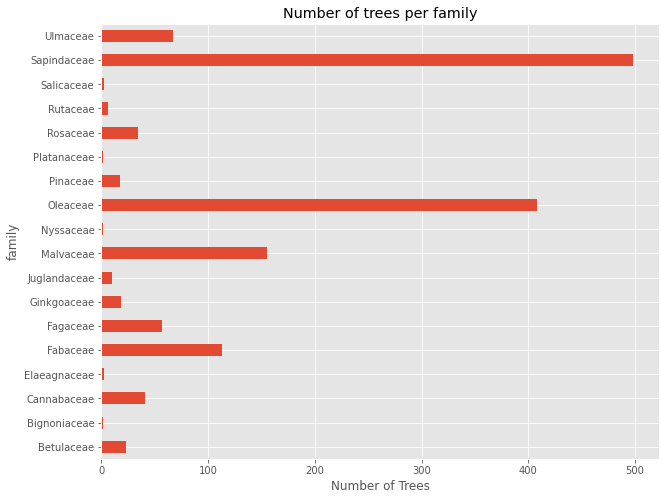

In [103]:
# Histogram of families
plt.title('Number of trees per family')
plt.xlabel('Number of Trees')
trees.groupby('family')['id'].nunique().plot(kind='barh', figsize=(10,8))

Text(0.5, 0, 'Genus')

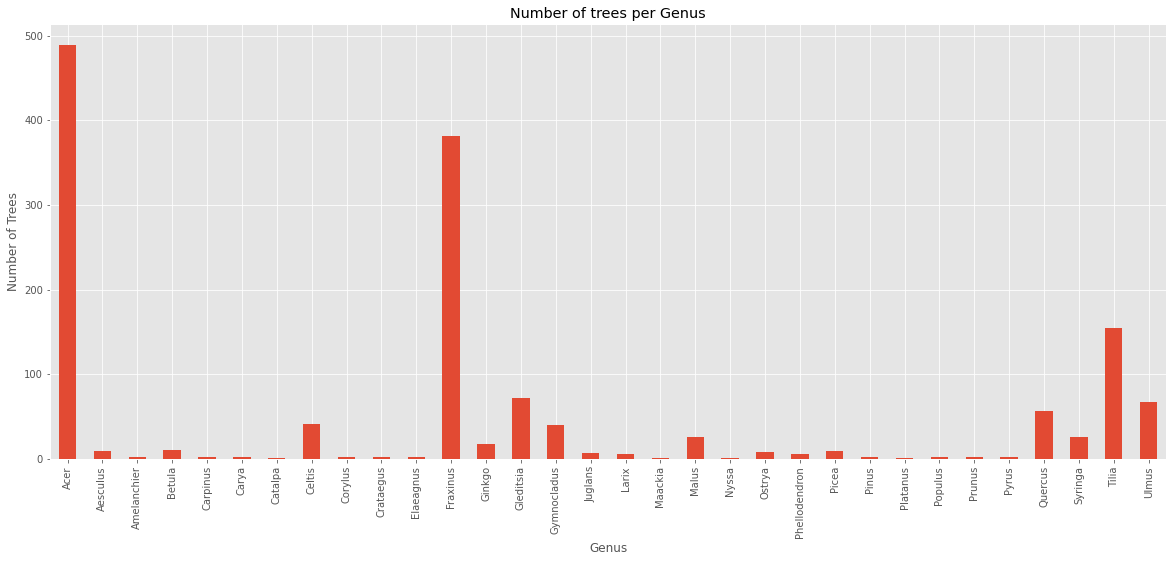

In [104]:
# Histogram of genus
plt.title('Number of trees per Genus')
plt.ylabel('Number of Trees')
trees.groupby('genus')['id'].nunique().plot(kind='bar', figsize=(20,8))
plt.xlabel('Genus')

<AxesSubplot:title={'center':'Number of different species per family'}, xlabel='Number of different species', ylabel='family'>

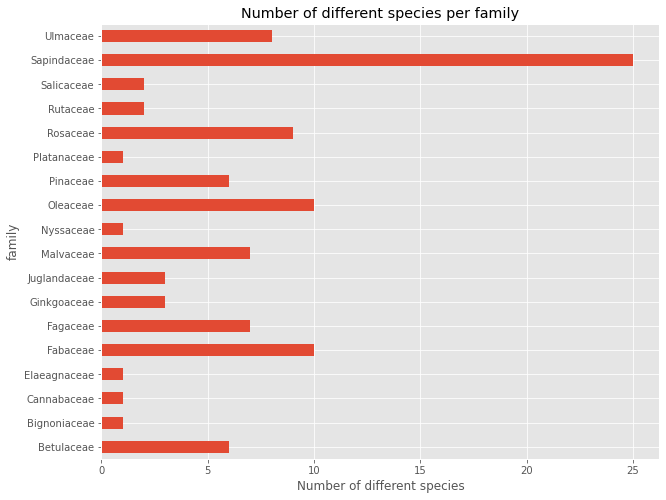

In [105]:
# Number of different species in each family
plt.title('Number of different species per family')
plt.xlabel('Number of different species')
trees.groupby('family')['specie_latin'].nunique().plot(kind='barh', figsize=(10,8))

In [106]:
# List of genres by family, according to planted trees.
trees.groupby('family')['genus'].unique()

family
Betulaceae                 [Ostrya, Corylus, Betula, Carpinus]
Bignoniaceae                                         [Catalpa]
Cannabaceae                                           [Celtis]
Elaeagnaceae                                       [Elaeagnus]
Fabaceae                     [Gleditsia, Gymnocladus, Maackia]
Fagaceae                                             [Quercus]
Ginkgoaceae                                           [Ginkgo]
Juglandaceae                                  [Juglans, Carya]
Malvaceae                                              [Tilia]
Nyssaceae                                              [Nyssa]
Oleaceae                                   [Fraxinus, Syringa]
Pinaceae                                 [Picea, Pinus, Larix]
Platanaceae                                         [Platanus]
Rosaceae        [Crataegus, Malus, Prunus, Amelanchier, Pyrus]
Rutaceae                                       [Phellodendron]
Salicaceae                                      

In [107]:
# List of genres by func group, according to planted trees.
trees.groupby('func_group')['genus'].unique()

func_group
1A                                              [Picea]
1B                               [Pinus, Larix, Ginkgo]
2A                       [Acer, Tilia, Carpinus, Nyssa]
2B                                           [Aesculus]
2C    [Acer, Ulmus, Fraxinus, Celtis, Betula, Platanus]
3A             [Crataegus, Syringa, Amelanchier, Pyrus]
3B             [Ulmus, Malus, Prunus, Maackia, Catalpa]
4A                   [Quercus, Juglans, Carya, Corylus]
4B                  [Elaeagnus, Gleditsia, Gymnocladus]
5              [Ostrya, Populus, Phellodendron, Betula]
na                                           [Fraxinus]
Name: genus, dtype: object

Text(0, 0.5, 'Number of Trees')

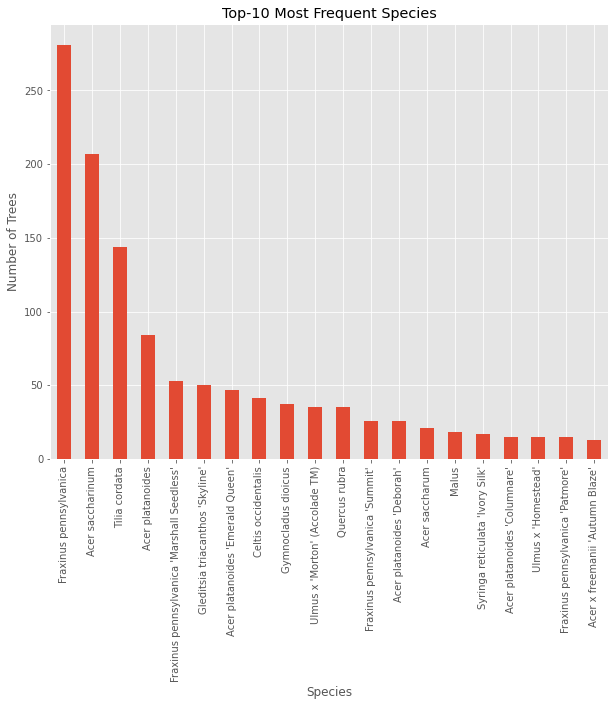

In [108]:
# Top-10 most frequent species
trees.groupby('specie_latin')['id'].nunique().sort_values(ascending=False).head(20).plot(kind='bar', figsize=(10,8))
plt.title('Top-10 Most Frequent Species')
plt.xlabel('Species')
plt.ylabel('Number of Trees')

In [109]:
# Species ordered by frequency on descending order
trees.groupby('specie_latin')['id'].nunique().sort_values(ascending=False)

specie_latin
Fraxinus pennsylvanica                        281
Acer saccharinum                              207
Tilia cordata                                 144
Acer platanoides                               84
Fraxinus pennsylvanica 'Marshall Seedless'     53
                                             ... 
Quercus muehlenbergii                           1
Amelanchier canadensis                          1
Quercus robur 'Crimson Spire'                   1
Quercus robur 'Fastigiata'                      1
Populus canescens 'Tower'                       1
Name: id, Length: 103, dtype: int64

Text(0, 0.5, 'Carbon Storage')

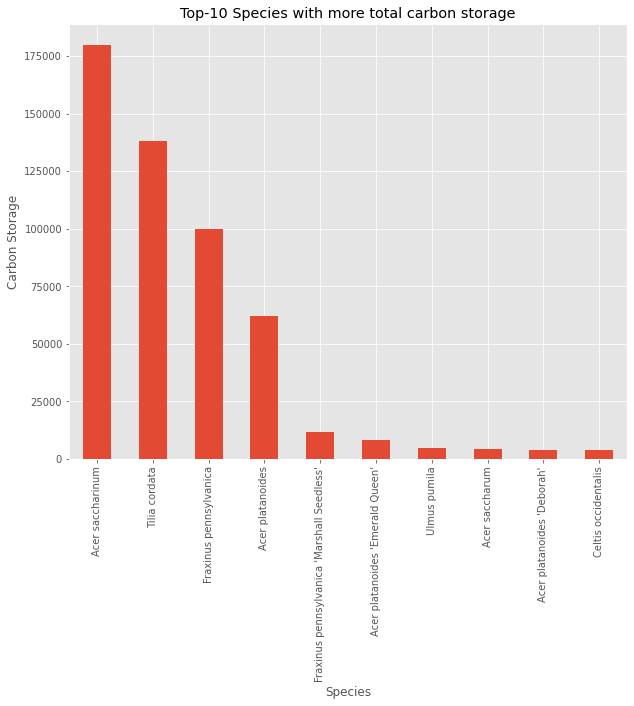

In [110]:
# Top-10 species in terms of carbon storage
trees.groupby('specie_latin')['carbon_storage'].sum().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(10,8))
plt.title('Top-10 Species with more total carbon storage')
plt.xlabel('Species')
plt.ylabel('Carbon Storage')

In [111]:
# Top species in terms of value
trees.groupby('specie_latin')['value'].sum().sort_values(ascending=False).head(40)

specie_latin
Acer saccharinum                             29792.290
Tilia cordata                                22880.194
Fraxinus pennsylvanica                       16557.628
Acer platanoides                             10280.854
Fraxinus pennsylvanica 'Marshall Seedless'    1953.724
Acer platanoides 'Emerald Queen'              1383.135
Ulmus pumila                                   763.557
Acer saccharum                                 693.618
Acer platanoides 'Deborah'                     665.188
Celtis occidentalis                            663.235
Fraxinus pennsylvanica 'Summit'                544.785
Gleditsia triacanthos 'Skyline'                459.544
Acer platanoides 'Schwedleri'                  456.773
Gleditsia triacanthos                          446.101
Fraxinus pennsylvanica 'Patmore'               426.078
Acer platanoides 'Summershade'                 284.643
Acer negundo                                   265.874
Acer platanoides 'Superform'                   260.2

Text(0, 0.5, 'Value')

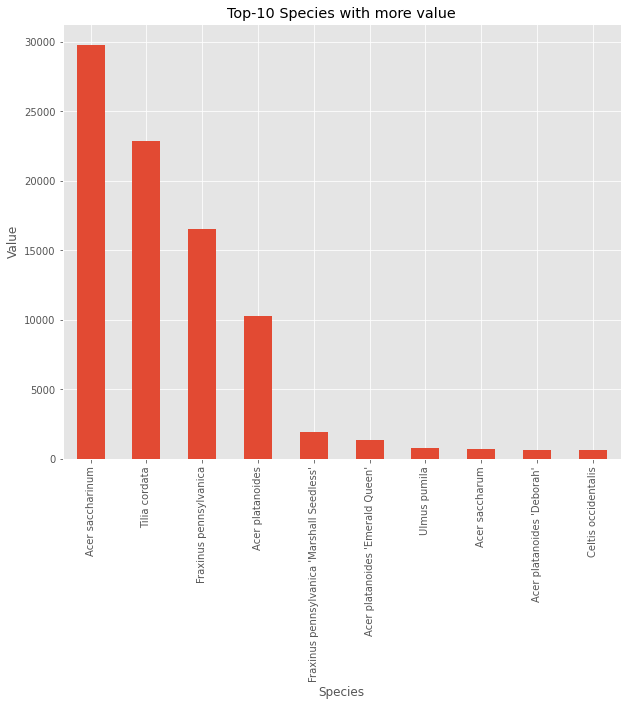

In [112]:
# Top-10 species in terms of value
trees.groupby('specie_latin')['value'].sum().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(10,8))
plt.title('Top-10 Species with more value')
plt.xlabel('Species')
plt.ylabel('Value')

In [113]:
# Top groups in terms of value
trees.groupby('func_group')['value'].sum().sort_values(ascending=False).head(40)

func_group
2C   51135.485
2A   38072.709
4B    1291.608
3B     940.332
4A     214.585
5      161.569
3A     152.059
1A     138.053
1B      35.178
na      17.901
2B       7.501
Name: value, dtype: float64

In [114]:
# Top groups in terms of carbon storage
trees.groupby('func_group')['carbon_storage'].sum().sort_values(ascending=False).head(40)

func_group
2C   308938.406
2A   230018.785
4B     7803.332
3B     5681.078
4A     1296.432
5       976.129
3A      918.674
1A      834.054
1B      212.531
na      108.152
2B       45.316
Name: carbon_storage, dtype: float64

In [115]:
# Top groups 
trees.groupby('func_group')['id'].nunique().sort_values(ascending=False).head(40)

func_group
2C    715
2A    418
4B    114
4A     69
3B     35
3A     32
1B     26
5      26
1A      9
2B      9
na      1
Name: id, dtype: int64

In [116]:
# Top genus
trees.groupby('genus')['id'].nunique().sort_values(ascending=False).head(40)

genus
Acer             489
Fraxinus         382
Tilia            155
Gleditsia         72
Ulmus             67
Quercus           57
Celtis            41
Gymnocladus       40
Malus             26
Syringa           26
Ginkgo            18
Betula            11
Picea              9
Aesculus           9
Ostrya             8
Juglans            7
Phellodendron      6
Larix              6
Carya              3
Carpinus           2
Elaeagnus          2
Pinus              2
Populus            2
Prunus             2
Pyrus              2
Crataegus          2
Corylus            2
Amelanchier        2
Catalpa            1
Nyssa              1
Maackia            1
Platanus           1
Name: id, dtype: int64

In [117]:
# Top genus per carbon storage
trees.groupby('genus')['carbon_storage'].sum().sort_values(ascending=False).head(40)

genus
Acer            273052.202
Tilia           140756.212
Fraxinus        119153.128
Gleditsia         7024.830
Ulmus             6600.331
Celtis            4006.979
Quercus           1022.243
Malus             1014.847
Picea              834.054
Populus            723.149
Syringa            598.921
Elaeagnus          414.776
Gymnocladus        363.726
Crataegus          305.027
Carya              231.163
Ostrya             139.764
Ginkgo             119.602
Betula              93.638
Platanus            77.735
Pinus               66.817
Aesculus            45.316
Prunus              36.411
Juglans             33.892
Phellodendron       31.245
Larix               26.112
Carpinus            13.680
Corylus              9.135
Catalpa              8.777
Pyrus                8.385
Maackia              7.964
Nyssa                6.488
Amelanchier          6.341
Name: carbon_storage, dtype: float64

In [118]:
# Top genus per value
trees.groupby('genus')['value'].sum().sort_values(ascending=False).head(40)

genus
Acer            45195.600
Tilia           23297.968
Fraxinus        19722.226
Gleditsia        1162.750
Ulmus            1092.487
Celtis            663.235
Quercus           169.202
Malus             167.977
Picea             138.053
Populus           119.696
Syringa            99.133
Elaeagnus          68.654
Gymnocladus        60.204
Crataegus          50.488
Carya              38.262
Ostrya             23.134
Ginkgo             19.797
Betula             15.499
Platanus           12.867
Pinus              11.060
Aesculus            7.501
Prunus              6.027
Juglans             5.610
Phellodendron       5.172
Larix               4.322
Carpinus            2.264
Corylus             1.512
Catalpa             1.453
Pyrus               1.388
Maackia             1.318
Nyssa               1.074
Amelanchier         1.049
Name: value, dtype: float64

### 2) Based on that, we can recommend species to be planted in that area. To do that, we let users decide the relevance of each aspect that they want to improve:

* w1: species_effective_diversity
* w2: species_richness
* w3: groups_effective_diversity
* w4: groups_richness
* w5: carbon_storage
* w6: tree value ($) 


In [119]:
w1 = 1 # species_effective_diversity
w2 = 1 # species_richness
w3 = 10 # group_effective_diversity
w4 = 1 # group_richness
w5 = 1 # carbon_storage
w6 = 1 # value

### 3) Once users give us the are and the weights, we should be able to generate a ranking of recommendations:

In [231]:
features_matrix = features_extractor(trees, candidates_df, species_df, biomass_df)
ranking = recommender(candidates_df,species_df,features_matrix,w1,w2,w3,w4,w5,w6)
ranking.head(20)

score             species_latin func_group  \
species_latin                                                          
Salix nigra              26.441               Salix nigra          5   
Salix sepulcralis        20.785         Salix sepulcralis          5   
Salix pentandra          20.785           Salix pentandra          5   
Salix miyabeana          20.785           Salix miyabeana          5   
Salix matsudana          20.785           Salix matsudana          5   
Populus sp.(hybrides)    20.031     Populus sp.(hybrides)          5   
Populus grandidentata    19.968     Populus grandidentata          5   
Populus balsamifera      18.654       Populus balsamifera          5   
Betula nigra             14.394              Betula nigra          5   
Betula pendula           14.394            Betula pendula          5   
Betula papyrifera        14.344         Betula papyrifera          5   
Alnus incana             14.121              Alnus incana          5   
Populus tremuloides      14.073       Populus tremuloides          5   
Populus canescens        13.971         Populus canescens          5   
Populus tremula          13.971           Populus tremula          5   
Populus nigra            13.971             Populus nigra          5   
Populus simonii          13.971           Populus simonii          5   
Populus canadensis       13.971        Populus canadensis          5   
Populus alba             13.971              Populus alba          5   
Cercidiphyllum japonicum 13.805  Cercidiphyllum japonicum          5   

                                   genus             family  \
species_latin                                                 
Salix nigra                        Salix         Salicaceae   
Salix sepulcralis                  Salix         Salicaceae   
Salix pentandra                    Salix         Salicaceae   
Salix miyabeana                    Salix         Salicaceae   
Salix matsudana                    Salix         Salicaceae   
Populus sp.(hybrides)            Populus         Salicaceae   
Populus grandidentata            Populus         Salicaceae   
Populus balsamifera              Populus         Salicaceae   
Betula nigra                      Betula         Betulaceae   
Betula pendula                    Betula         Betulaceae   
Betula papyrifera                 Betula         Betulaceae   
Alnus incana                       Alnus         Betulaceae   
Populus tremuloides              Populus         Salicaceae   
Populus canescens                Populus         Salicaceae   
Populus tremula                  Populus         Salicaceae   
Populus nigra                    Populus         Salicaceae   
Populus simonii                  Populus         Salicaceae   
Populus canadensis               Populus         Salicaceae   
Populus alba                     Populus         Salicaceae   
Cercidiphyllum japonicum  Cercidiphyllum  Cercidiphyllaceae   

                          species_diversity_improvement  \
species_latin                                             
Salix nigra                                       0.007   
Salix sepulcralis                                 0.007   
Salix pentandra                                   0.007   
Salix miyabeana                                   0.007   
Salix matsudana                                   0.007   
Populus sp.(hybrides)                             0.007   
Populus grandidentata                             0.007   
Populus balsamifera                               0.007   
Betula nigra                                      0.007   
Betula pendula                                    0.007   
Betula papyrifera                                 0.007   
Alnus incana                                      0.007   
Populus tremuloides                               0.007   
Populus canescens                                 0.007   
Populus tremula                                   0.007   
Populus nigra                                     0

In [177]:
ranking.tail()

score         species_latin func_group     genus  \
species_latin                                                             
Tilia cordata        -20.628         Tilia cordata         2A     Tilia   
Tilia americana      -20.984       Tilia americana         2A     Tilia   
Cornus alternifolia  -21.064   Cornus alternifolia         2A    Cornus   
Ostrya virginiana    -21.868     Ostrya virginiana         2A    Ostrya   
Carpinus caroliniana -22.851  Carpinus caroliniana         2A  Carpinus   

                          family  species_diversity_improvement  \
species_latin                                                     
Tilia cordata          Malvaceae                          0.004   
Tilia americana        Malvaceae                          0.004   
Cornus alternifolia    Cornaceae                          0.005   
Ostrya virginiana     Betulaceae                          0.004   
Carpinus caroliniana  Betulaceae                          0.002   

                      species_richness_improvement  \
species_latin                                        
Tilia cordata                                0.000   
Tilia americana                              0.000   
Cornus alternifolia                          0.000   
Ostrya virginiana                            0.000   
Carpinus caroliniana                         0.000   

                      groups_diversity_improvement  \
species_latin                                        
Tilia cordata                                0.000   
Tilia americana                              0.000   
Cornus alternifolia                          0.000   
Ostrya virginiana                            0.000   
Carpinus caroliniana                         0.000   

                      groups_richness_improvement  carbon_storage_improvement  \
species_latin                                                                   
Tilia cordata                               0.000                       0.003   
Tilia americana                             0.000                       0.002   
Cornus alternifolia                         0.000                       0.000   
Ostrya virginiana                           0.000                       0.001   
Carpinus caroliniana                        0.000                       0.001   

                      value_increase  
species_latin                         
Tilia cordata                  0.003  
Tilia americana                0.002  
Cornus alternifolia            0.000  
Ostrya virginiana              0.001  
Carpinus caroliniana           0.001

In [178]:
df_group_number = trees.groupby(['func_group']).size()
df_group_number

func_group
1A    166
1B    111
2A    335
2B      9
2C    157
3A     51
3B     53
4A     32
4B     61
5      20
na     30
dtype: int64

### 5) Supose that users want to follow our recommendation. They should be able to check the effects of planting k trees of that species, here we take the top 10 recommended species:
- Compute a number of trees to plant according to the total nb of trees in the selection and a given percentage (5%)
- According to the recommendations, checking if it respects the santamour rule if we plant a tenth of this number. Discarding the species that are not compliant with the rule
- Selecting the top 10 species to plant. We plant a tenth of each species of the number of trees to plant

In [220]:
print("nb trees to plant", num_trees_to_plant)
print("Actual nb trees: ",len(trees))
predict_status(trees, candidates_df, select_trees_to_plant(ranking, trees, 5))

nb trees to plant 51
Actual nb trees:  1025


d:\projects\urban_project\sylvcit-new\app\env_recommender\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
d:\projects\urban_project\sylvcit-new\app\env_recommender\lib\site-packages\ipykernel_launcher.py:521: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
d:\projects\urban_project\sylvcit-new\app\env_recommender\lib\site-packages\ipykernel_launcher.py:547: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Predicted nb trees:  1075


curr_status  prediction  improvement  \
species_diversity          26.615      30.575        3.959   
group_diversity             7.307       7.764        0.457   
species_richness           68.000      77.000        9.000   
group_richness             11.000      11.000        0.000   
total_carbon_storage   144495.549  146599.389     2103.840   
total_value             23916.903   24265.131      348.228   

                      improvement_porcentage  
species_diversity                      0.149  
group_diversity                        0.063  
species_richness                       0.132  
group_richness                         0.000  
total_carbon_storage                   0.015  
total_value                            0.015

In [201]:

# Predict the status after planting 10 trees of species 'Pinus Rigida'
print("Actual nb trees: ",len(trees))
trees_list = top_10_species
predict_status(trees, candidates_df, trees_list)

Actual nb trees:  1025


d:\projects\urban_project\sylvcit-new\app\env_recommender\lib\site-packages\ipykernel_launcher.py:521: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
d:\projects\urban_project\sylvcit-new\app\env_recommender\lib\site-packages\ipykernel_launcher.py:547: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Predicted nb trees:  1035


curr_status  prediction  improvement  \
species_diversity          26.615      27.840        1.225   
group_diversity             7.307       7.430        0.124   
species_richness           68.000      78.000       10.000   
group_richness             11.000      11.000        0.000   
total_carbon_storage   144495.549  144909.485      413.936   
total_value             23916.903   23985.418       68.515   

                      improvement_porcentage  
species_diversity                      0.046  
group_diversity                        0.017  
species_richness                       0.147  
group_richness                         0.000  
total_carbon_storage                   0.003  
total_value                            0.003

In [280]:
parks = ["BEAUBIEN", "JARRY", "LACOURSIÈRE", "GABRIEL-LALEMANT", "AHUNTSIC", "MAISONNEUVE, DE",
        "LA FONTAINE", "JEANNE-MANCE", "ANGRIGNON", "Parc Delorme"]
park_trees = []
for park in parks:
    trees = {}
    trees["trees"] = get_trees_bypark(park)
    trees["park_name"] = park
    trees["nb_trees"] = len(trees["trees"])
    trees["trees_to_plant"] = round((len(trees["trees"])/100)*5)
    print(trees["park_name"] , trees["nb_trees"], trees["trees_to_plant"])
    park_trees.append(trees)

# print(json.dumps(park_trees[0], indent=4, sort_keys=True))

BEAUBIEN
BEAUBIEN 257 13
JARRY
JARRY 2299 115
LACOURSIÈRE
LACOURSIÈRE 346 17
GABRIEL-LALEMANT
GABRIEL-LALEMANT 176 9
AHUNTSIC
AHUNTSIC 944 47
MAISONNEUVE, DE
MAISONNEUVE, DE 6329 316
LA FONTAINE
LA FONTAINE 2862 143
JEANNE-MANCE
JEANNE-MANCE 407 20
ANGRIGNON
ANGRIGNON 935 47
Parc Delorme
Parc Delorme 1025 51


Park name  BEAUBIEN
Number of trees in the park  257
func_group
1A    18
1B    47
2A    70
2B     9
2C    16
3A    10
3B    21
4A    15
4B    24
5     15
na    12
dtype: int64
specie_latin_cleaned
Acer platanoides         55
Gleditsia triacanthos    14
Larix laricina           13
Pinus nigra              11
Ulmus pumila             11
Gymnocladus dioicus      10
Tilia americana          10
Aesculus glabra           9
Ginkgo biloba             9
Pinus sylvestris          9
dtype: int64
Actual nb trees:  257
nb trees to plant 13


d:\projects\urban_project\sylvcit-new\app\env_recommender\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
d:\projects\urban_project\sylvcit-new\app\env_recommender\lib\site-packages\ipykernel_launcher.py:521: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
d:\projects\urban_project\sylvcit-new\app\env_recommender\lib\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

Predicted nb trees:  267
func_group
1A    18
1B    47
2A    70
2B     9
2C    19
3A    13
3B    21
4A    16
4B    24
5     18
na    12
dtype: int64
                   curr_status  new_status
index                                     
species_diversity       24.852      28.180
group_diversity          8.745       8.976
species_richness        40.000      50.000
group_richness          11.000      11.000


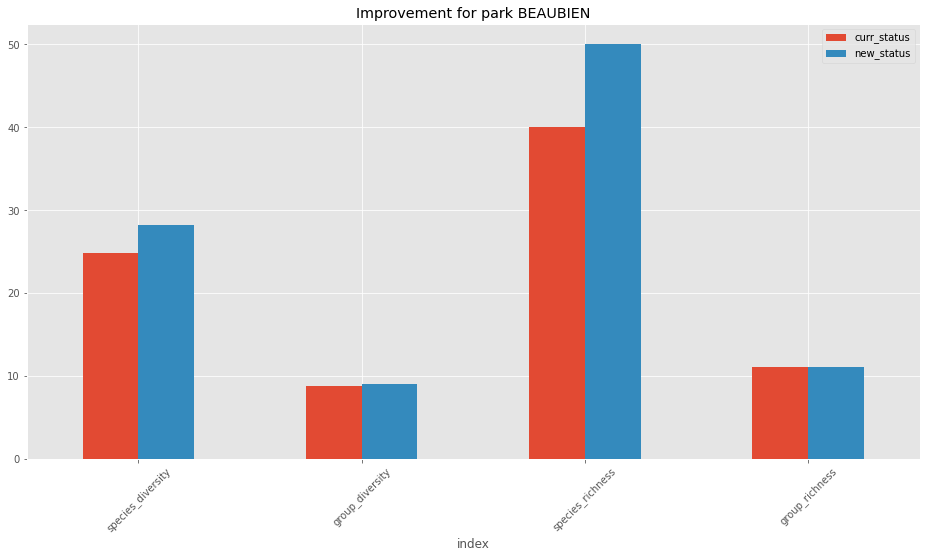

-------------------
Park name  JARRY
Number of trees in the park  2299
func_group
1A    353
1B    377
2A    354
2B      5
2C    367
3A     55
3B    251
4A    251
4B    192
5      69
na     25
dtype: int64
specie_latin_cleaned
Picea pungens             246
Gleditsia triacanthos     171
Pinus nigra               171
Fraxinus pennsylvanica    151
Tilia cordata             142
Ulmus pumila              129
Quercus macrocarpa        110
Acer platanoides          108
Pinus sylvestris           82
Acer saccharinum           73
dtype: int64
Actual nb trees:  2299
nb trees to plant 115


d:\projects\urban_project\sylvcit-new\app\env_recommender\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
d:\projects\urban_project\sylvcit-new\app\env_recommender\lib\site-packages\ipykernel_launcher.py:521: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
d:\projects\urban_project\sylvcit-new\app\env_recommender\lib\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

Predicted nb trees:  2395
func_group
1A    353
1B    377
2A    354
2B      5
2C    367
3A     91
3B    251
4A    251
4B    204
5     117
na     25
dtype: int64
                   curr_status  new_status
index                                     
species_diversity       31.999      35.494
group_diversity          8.274       8.655
species_richness        76.000      82.000
group_richness          11.000      11.000


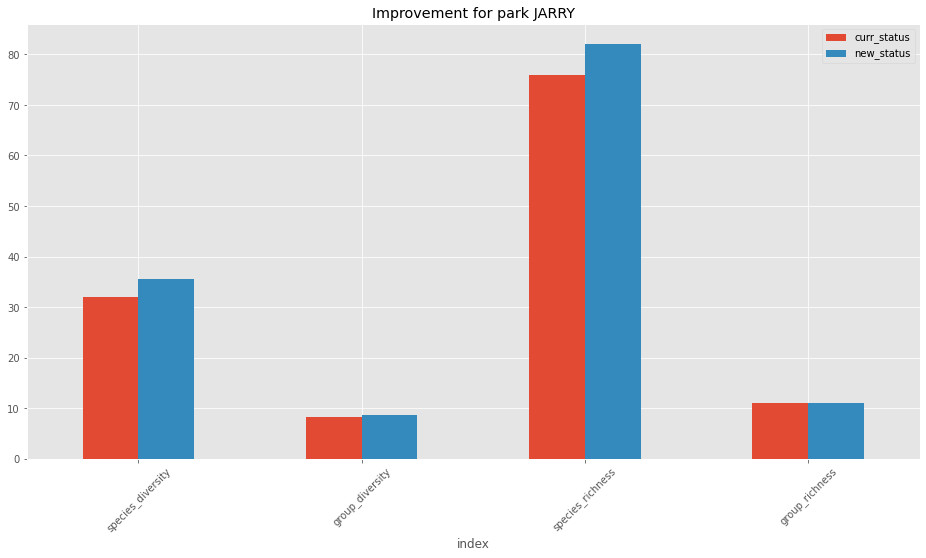

-------------------
Park name  LACOURSIÈRE
Number of trees in the park  346
func_group
1A     33
1B      5
2A     27
2B      3
2C     92
3B     25
4A      6
4B      3
5     146
na      6
dtype: int64
specie_latin_cleaned
Populus deltoides         95
Fraxinus americana        42
Salix alba                39
Fraxinus pennsylvanica    25
Picea abies               23
Acer negundo              18
Acer platanoides          16
Prunus serotina           13
Populus tremuloides       11
Malus sp.                  8
dtype: int64
Actual nb trees:  346
nb trees to plant 17


d:\projects\urban_project\sylvcit-new\app\env_recommender\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
d:\projects\urban_project\sylvcit-new\app\env_recommender\lib\site-packages\pandas\core\dtypes\common.py:1776: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  npdtype = np.dtype(dtype)
d:\projects\urban_project\sylvcit-new\app\env_recommender\lib\site-packages\ipykernel_launcher.py:521: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
d:\project

Predicted nb trees:  362
func_group
1A     33
1B      9
2A     27
2B      3
2C     92
3A      4
3B     27
4A      8
4B      7
5     146
na      6
dtype: int64
                   curr_status  new_status
index                                     
species_diversity       13.484      15.792
group_diversity          5.020       5.639
species_richness        32.000      40.000
group_richness          10.000      11.000


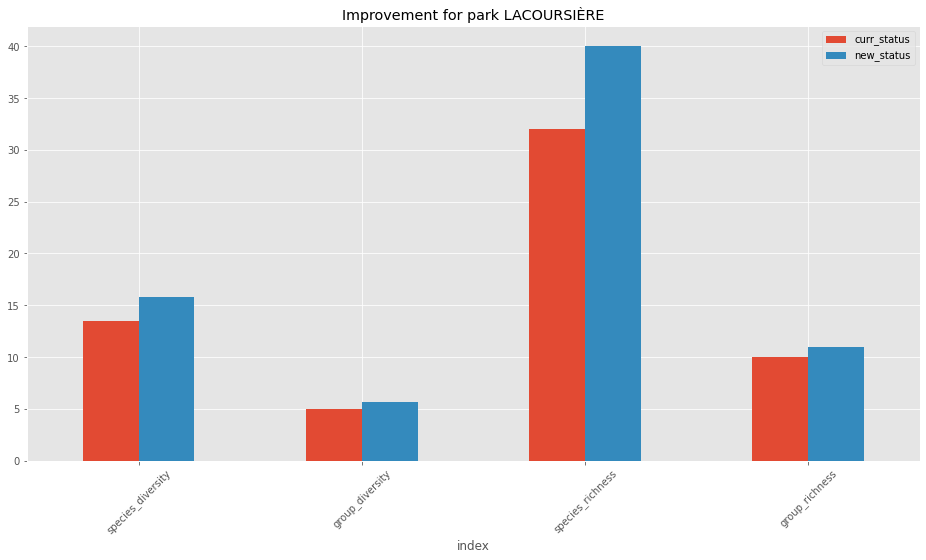

-------------------
Park name  GABRIEL-LALEMANT
Number of trees in the park  176
func_group
1A    10
1B    10
2A    55
2B     1
2C    35
3A     8
3B    13
4A     5
4B    27
5     12
dtype: int64
specie_latin_cleaned
Acer saccharum           24
Gleditsia triacanthos    20
Tilia cordata            14
Acer saccharinum         11
Ulmus x                  10
Acer platanoides          8
Ginkgo biloba             6
Gymnocladus dioicus       6
Malus sp.                 6
Celtis occidentalis       5
dtype: int64
Actual nb trees:  176
nb trees to plant 9


d:\projects\urban_project\sylvcit-new\app\env_recommender\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
d:\projects\urban_project\sylvcit-new\app\env_recommender\lib\site-packages\pandas\core\dtypes\common.py:1776: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  npdtype = np.dtype(dtype)
d:\projects\urban_project\sylvcit-new\app\env_recommender\lib\site-packages\ipykernel_launcher.py:521: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
d:\project

Predicted nb trees:  186
func_group
1A    11
1B    11
2A    55
2B     1
2C    35
3A     9
3B    14
4A     9
4B    27
5     14
dtype: int64
                   curr_status  new_status
index                                     
species_diversity       26.993      31.318
group_diversity          6.992       7.388
species_richness        47.000      56.000
group_richness          10.000      10.000


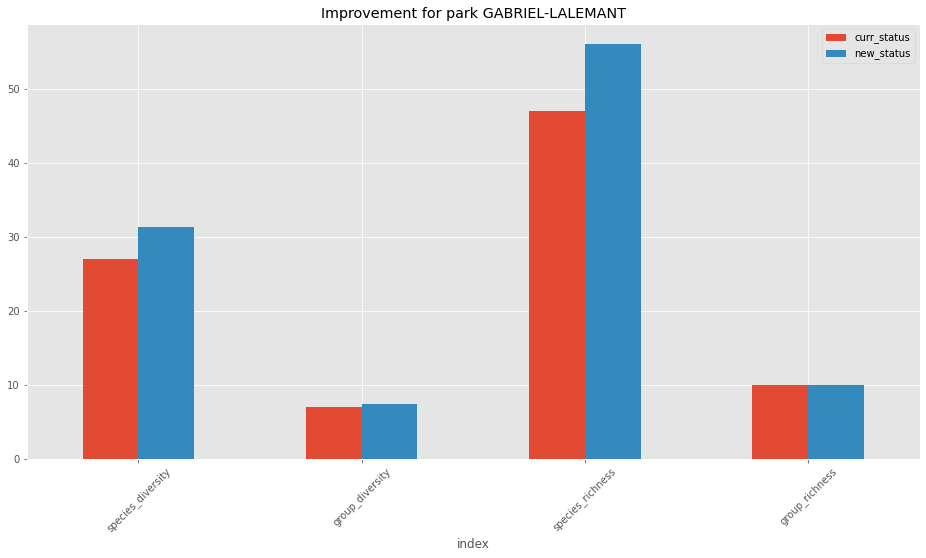

-------------------
Park name  AHUNTSIC
Number of trees in the park  944
func_group
1A    215
1B     56
2A    237
2B      4
2C    247
3A     24
3B     50
4A     47
4B     27
5      34
na      3
dtype: int64
specie_latin_cleaned
Acer platanoides          139
Picea pungens             139
Acer saccharinum           85
Fraxinus pennsylvanica     81
Picea glauca               44
Acer saccharum             39
Pinus nigra                39
Acer negundo               31
Gleditsia triacanthos      19
Malus sp.                  19
dtype: int64
Actual nb trees:  944
nb trees to plant 47


d:\projects\urban_project\sylvcit-new\app\env_recommender\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
d:\projects\urban_project\sylvcit-new\app\env_recommender\lib\site-packages\ipykernel_launcher.py:521: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
d:\projects\urban_project\sylvcit-new\app\env_recommender\lib\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

Predicted nb trees:  994
func_group
1A    215
1B     56
2A    237
2B      4
2C    247
3A     34
3B     50
4A     47
4B     47
5      54
na      3
dtype: int64
                   curr_status  new_status
index                                     
species_diversity       25.869      29.894
group_diversity          6.446       6.913
species_richness        73.000      82.000
group_richness          11.000      11.000


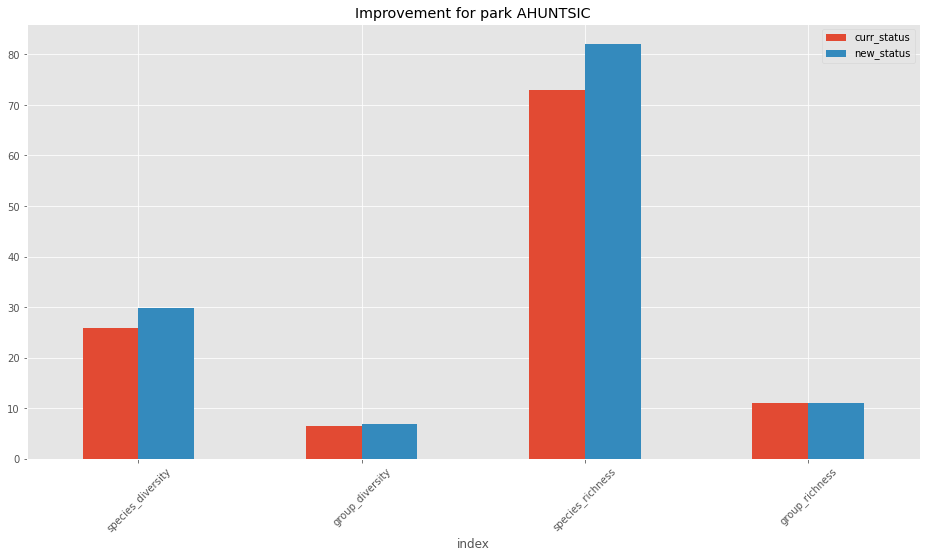

-------------------
Park name  MAISONNEUVE, DE
Number of trees in the park  6329
func_group
1A    1748
1B     903
2A     426
2B      29
2C    1278
3A     319
3B     423
4A     292
4B     235
5      490
na     186
dtype: int64
specie_latin_cleaned
Picea pungens             1189
Fraxinus pennsylvanica     487
Pinus sylvestris           418
Larix decidua              338
Acer saccharinum           273
Picea glauca               269
Ulmus americana            259
Crataegus sp.              256
Gleditsia triacanthos      224
Tilia americana            175
dtype: int64
Actual nb trees:  6329
nb trees to plant 316


d:\projects\urban_project\sylvcit-new\app\env_recommender\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
d:\projects\urban_project\sylvcit-new\app\env_recommender\lib\site-packages\ipykernel_launcher.py:521: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
d:\projects\urban_project\sylvcit-new\app\env_recommender\lib\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

Predicted nb trees:  6649
func_group
1A    1748
1B     903
2A     426
2B      29
2C    1278
3A     383
3B     423
4A     388
4B     363
5      522
na     186
dtype: int64
                   curr_status  new_status
index                                     
species_diversity       29.122      33.226
group_diversity          7.845       8.192
species_richness        81.000      89.000
group_richness          11.000      11.000


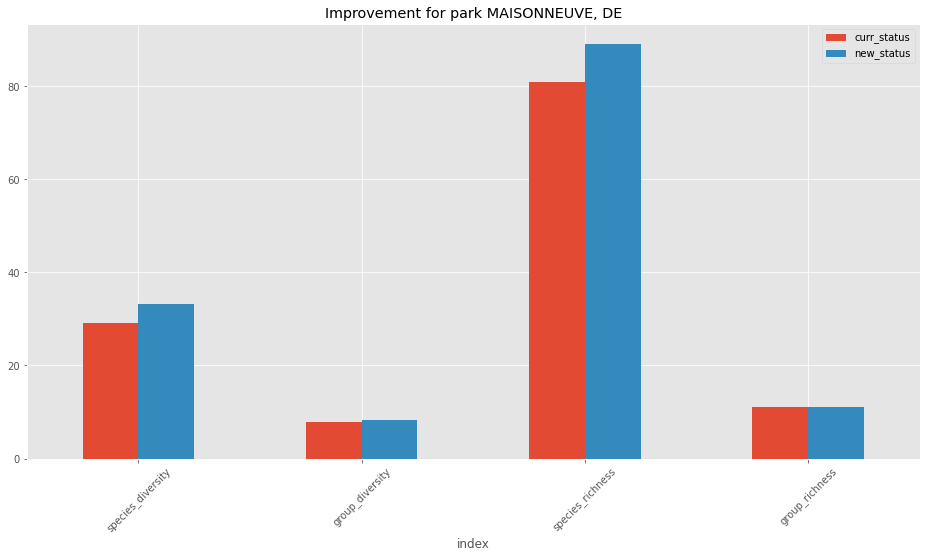

-------------------
Park name  LA FONTAINE
Number of trees in the park  2862
func_group
1A     145
1B     197
2A     693
2B      14
2C    1222
3A      59
3B     167
4A     189
4B      58
5      112
na       6
dtype: int64
specie_latin_cleaned
Acer saccharinum          770
Acer platanoides          374
Tilia cordata             130
Acer rubrum               119
Celtis occidentalis       114
Fraxinus pennsylvanica    110
Picea pungens              90
Pinus nigra                77
Larix laricina             74
Quercus rubra              65
dtype: int64
Actual nb trees:  2862
nb trees to plant 143


d:\projects\urban_project\sylvcit-new\app\env_recommender\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
d:\projects\urban_project\sylvcit-new\app\env_recommender\lib\site-packages\ipykernel_launcher.py:521: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
d:\projects\urban_project\sylvcit-new\app\env_recommender\lib\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

Predicted nb trees:  3002
func_group
1A     145
1B     197
2A     693
2B      14
2C    1222
3A     101
3B     167
4A     189
4B     114
5      154
na       6
dtype: int64
                   curr_status  new_status
index                                     
species_diversity       22.589      26.089
group_diversity          5.541       6.004
species_richness        89.000      98.000
group_richness          11.000      11.000


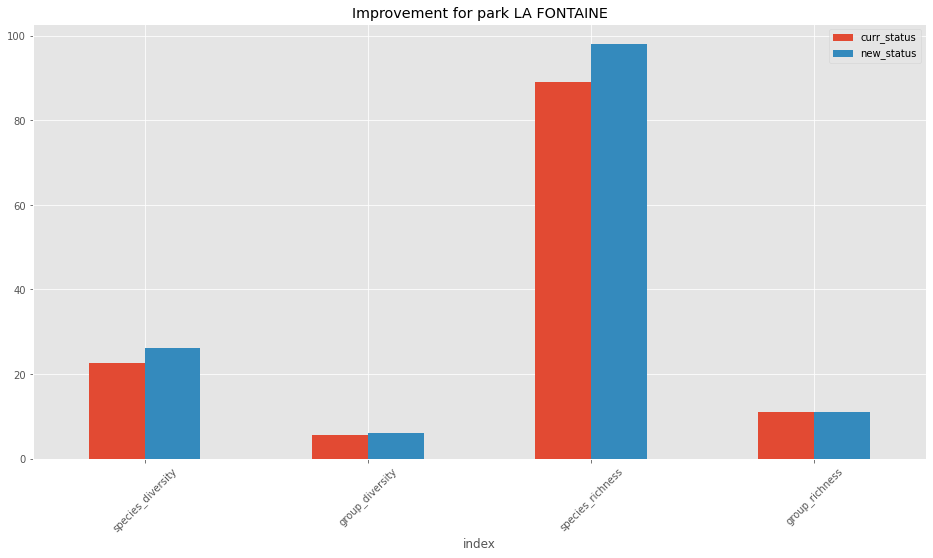

-------------------
Park name  JEANNE-MANCE
Number of trees in the park  407
func_group
1A     11
1B      4
2A     40
2C    314
3B      8
4A     21
4B      6
5       3
dtype: int64
specie_latin_cleaned
Acer saccharinum       285
Tilia americana         19
Celtis occidentalis     15
Ulmus americana         13
Picea pungens           11
Acer platanoides        10
Acer saccharum           7
Quercus macrocarpa       6
Malus sp.                4
Pinus nigra              4
dtype: int64
Actual nb trees:  407
nb trees to plant 20


d:\projects\urban_project\sylvcit-new\app\env_recommender\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
d:\projects\urban_project\sylvcit-new\app\env_recommender\lib\site-packages\pandas\core\dtypes\common.py:1776: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  npdtype = np.dtype(dtype)
d:\projects\urban_project\sylvcit-new\app\env_recommender\lib\site-packages\ipykernel_launcher.py:521: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
d:\project

Predicted nb trees:  427
func_group
1A     11
1B      8
2A     40
2C    314
3A      6
3B     10
4A     21
4B      6
5      11
dtype: int64
                   curr_status  new_status
index                                     
species_diversity        4.256       5.318
group_diversity          2.459       2.906
species_richness        25.000      34.000
group_richness           8.000       9.000


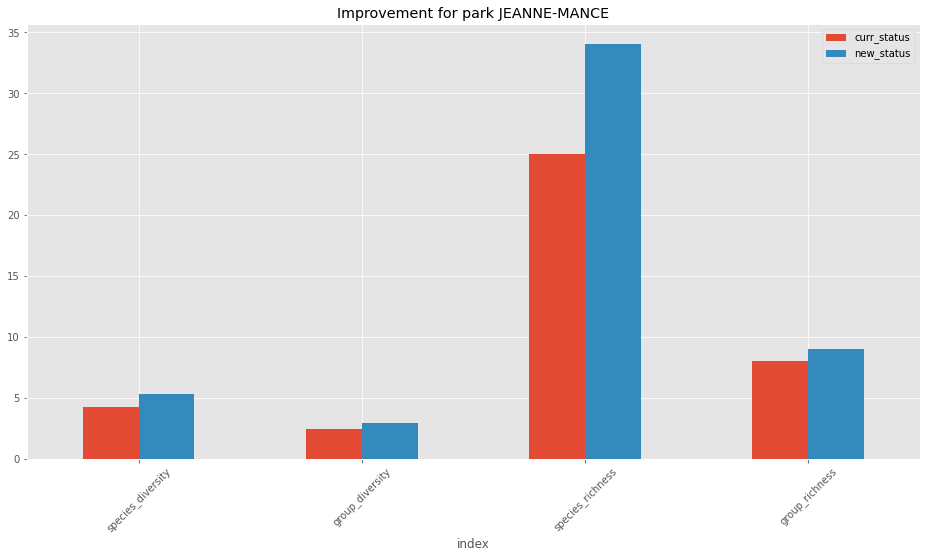

-------------------
Park name  ANGRIGNON
Number of trees in the park  935
func_group
1A    146
1B     47
2A     50
2C    139
3A      3
3B     14
4A     68
4B      8
5     456
na      4
dtype: int64
specie_latin_cleaned
Populus x canadensis      247
Populus deltoides         148
Picea pungens              69
Picea glauca               48
Fraxinus pennsylvanica     47
Acer saccharinum           39
Populus x canescens        39
Quercus rubra              34
Larix laricina             31
Picea abies                23
dtype: int64
Actual nb trees:  935
nb trees to plant 47


d:\projects\urban_project\sylvcit-new\app\env_recommender\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
d:\projects\urban_project\sylvcit-new\app\env_recommender\lib\site-packages\ipykernel_launcher.py:521: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
d:\projects\urban_project\sylvcit-new\app\env_recommender\lib\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

Predicted nb trees:  985
func_group
1A    146
1B     47
2A     50
2C    139
3A     18
3B     34
4A     68
4B     23
5     456
na      4
dtype: int64
                   curr_status  new_status
index                                     
species_diversity       15.789      18.857
group_diversity          4.790       5.454
species_richness        41.000      51.000
group_richness          10.000      10.000


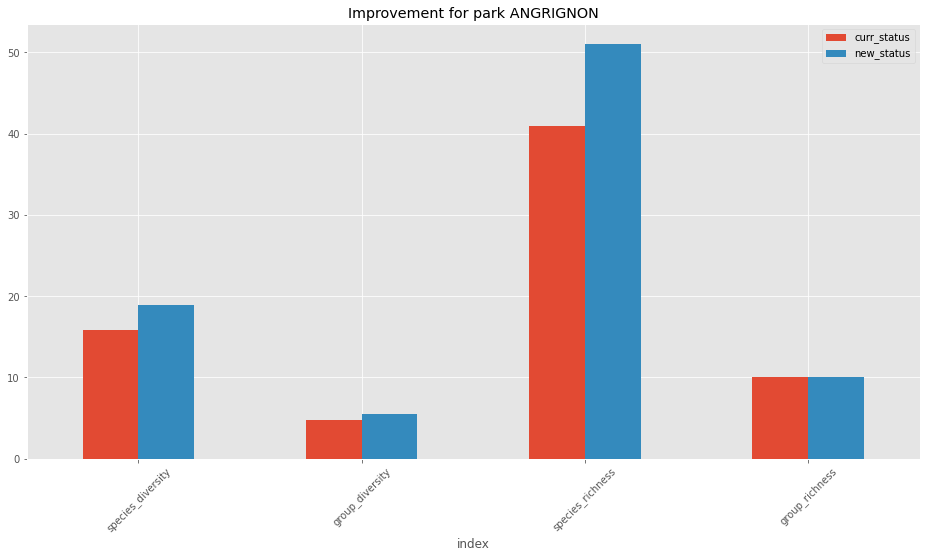

-------------------
Park name  Parc Delorme
Number of trees in the park  1025
func_group
1A    166
1B    111
2A    335
2B      9
2C    157
3A     51
3B     53
4A     32
4B     61
5      20
na     30
dtype: int64
specie_latin_cleaned
Acer platanoides          194
Picea glauca               84
Picea pungens              73
Acer ginnala               69
Amelanchier canadensis     45
Pinus sylvestris           44
Acer saccharinum           42
Gleditsia triacanthos      40
Celtis occidentalis        38
Larix laricina             33
dtype: int64
Actual nb trees:  1025
nb trees to plant 51


d:\projects\urban_project\sylvcit-new\app\env_recommender\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
d:\projects\urban_project\sylvcit-new\app\env_recommender\lib\site-packages\ipykernel_launcher.py:521: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
d:\projects\urban_project\sylvcit-new\app\env_recommender\lib\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

Predicted nb trees:  1075
func_group
1A    166
1B    111
2A    335
2B      9
2C    157
3A     56
3B     63
4A     47
4B     61
5      40
na     30
dtype: int64
                   curr_status  new_status
index                                     
species_diversity       26.615      30.378
group_diversity          7.307       7.764
species_richness        68.000      76.000
group_richness          11.000      11.000


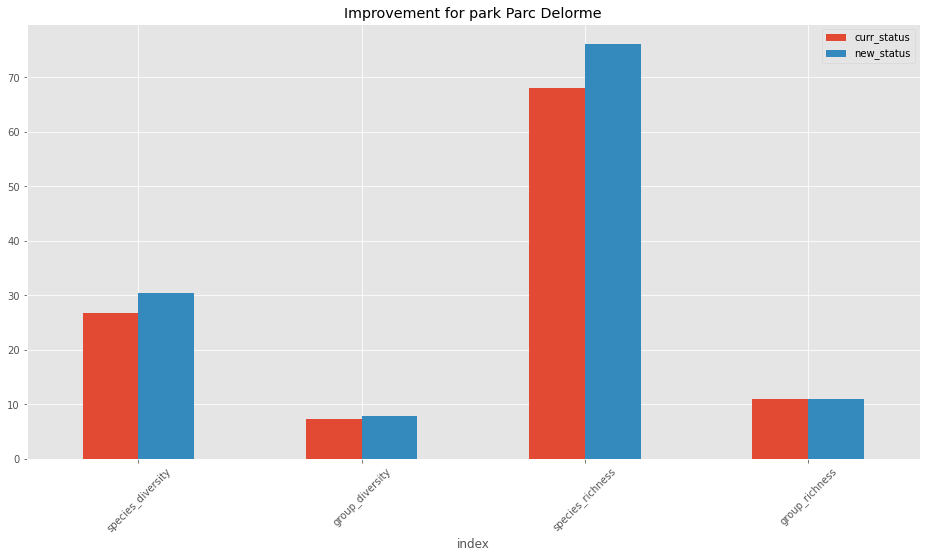

-------------------


In [281]:
from pprint import pprint
for park in park_trees:
    print("Park name ",park["park_name"])
    print("Number of trees in the park ",park["nb_trees"])
    trees = pd.DataFrame(park["trees"] )
    df_group_number = trees.groupby(['func_group']).size()
    print(df_group_number)
    df_species_number = trees.groupby(['specie_latin_cleaned']).size().nlargest(10)
    print(df_species_number)
    features_matrix = features_extractor(trees, candidates_df, species_df, biomass_df, trees_location="parks")
    ranking = recommender(candidates_df,species_df,features_matrix,w1,w2,w3,w4,w5,w6)
    print("Actual nb trees: ",len(trees))
    predicted_status = predict_status(trees, candidates_df, select_trees_to_plant(ranking, trees, 5))
    predicted_status.reset_index(inplace=True)
    predicted_status = predicted_status[predicted_status["index"]!= "total_carbon_storage"]
    predicted_status = predicted_status[predicted_status["index"]!= "total_value"]
    predicted_status = predicted_status.drop(['improvement_percentage', 'improvement'], axis=1)
    predicted_status = predicted_status.set_index('index')
#     print(predicted_status.to_dict())
#     print(type(predicted_status))
    pprint(predicted_status)
    predicted_status.plot(kind='bar', figsize=(16,8), title="Improvement for park "+park['park_name'], rot=45)
    plt.show()
    print("-------------------")

([<matplotlib.axis.XTick at 0x166daffc9e8>,
 [Text(0, 0, 'species_diversity'),
  Text(1, 0, 'group_diversity'),
  Text(2, 0, 'species_richness'),
  Text(3, 0, 'group_richness')])

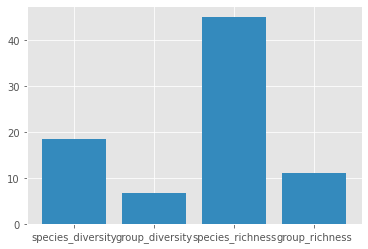

In [278]:
test_dict = {'curr_status': {'species_diversity': 18.4420053530137, 
                             'group_diversity': 6.605701074679462, 
                             'species_richness': 45.0, 
                             'group_richness': 11.0},
#                              'total_carbon_storage': 24451.60869835999, 
#                              'total_value': 4047.2302717525454}, 
             'prediction': {'species_diversity': 21.17746622846123, 
                            'group_diversity': 7.016620973282681, 
                            'species_richness': 54.0, 
                            'group_richness': 11.0}, 
#                             'total_carbon_storage': 24862.455096829806, 
#                             'total_value': 4115.233567627271}, 
             'improvement': {'species_diversity': 2.735460875447533, 
                             'group_diversity': 0.4109198986032183, 
                             'species_richness': 9.0, 
                             'group_richness': 0.0, 
                             'total_carbon_storage': 410.84639846981736, 
                             'total_value': 68.00329587472606}, 
             'improvement_porcentage': {
                 'species_diversity': 14.832773459750232, 
                 'group_diversity': 6.220685646499042, 
                 'species_richness': 20.0, 
                 'group_richness': 0.0, 
                 'total_carbon_storage': 1.680242815669521, 
                 'total_value': 1.6802428156695675}}
plt.bar(range(len(test_dict['curr_status'])), list(test_dict['curr_status'].values()), align='center')
plt.bar(range(len(test_dict['curr_status'])), list(test_dict['curr_status'].values()), align='center')
plt.xticks(range(len(test_dict['curr_status'])), list(test_dict['curr_status'].keys()))